In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from plotly.subplots import make_subplots
import ast
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

In [28]:
movies_df = pd.read_csv("data/preprocessed/preprocessed_movies.csv")
for col in movies_df.columns:
    try:
        movies_df[col] = movies_df[col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
    except:
        pass


movies_df.head(5)

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
0,$,NaN,[Russia],"[Comedy, Drama, Crime]",1971,Western,"[Joe Collins, American bank security consultan...","[Dawn Divine, hooker with a heart of gold, cun...",[None],"[Resourcefulness, cleverness, individualism, h...",[None]
1,"$1,000 on the Black","[Italian, German]","[Germany, Italy]",[Western],1966,Eastern,[None],"[Sartana, villainous, oppressive, cruel, arche...","[Johnny Liston, justice, determination, resili...","[Justice, revenge, oppressed vs. oppressor, re...","[Terror, betrayal, familial conflict, crime, r..."
2,"$10,000 Blood Money",NaN,[Russia],"[Drama, Western]",1967,None,[None],[None],[None],[None],"[crime, betrayal, revenge, bounty hunter, heis..."
3,"$100,000 for Ringo",[Italian],[Italy],"[Drama, Western]",1965,None,[None],[None],[None],[None],"[Western, Civil War, mistaken identity, treasu..."
4,'Anna' i wampir,NaN,[Russia],[Crime],1982,None,[None],[None],[None],[None],"[murder mystery, horror, fog, Poland, 1960s]"


# Genre Analysis

## Bar Plots


In [29]:
genres_df = movies_df[["countries", "cold_war_side", "genres", "release_date"]]
genres_df = genres_df.explode("genres")[genres_df.explode("genres") != "\\N"]
genres_df["genres"] = (
    genres_df["genres"].str.title().str.strip().replace({"Sci-Fi": "Science Fiction"})
)

genre_counts = genres_df["genres"].value_counts().head(20)
common_genres = genre_counts.head(12).index

In [30]:
def plot_side_by_side(
    western_count,
    eastern_count,
    x_column="language",
    y_column="count",
    title="Top 20 Languages",
    color_scale=["#1f77b4", "#ff6347"],
):
    # Create subplot
    fig = make_subplots(
        rows=1,
        cols=2,
        specs=[[{"type": "bar"}, {"type": "bar"}]],
        subplot_titles=("in Western Bloc Movies", "in Eastern Bloc Movies"),
    )

    # Western plot
    fig.add_trace(
        go.Bar(
            x=western_count[x_column].head(20),
            y=western_count[y_column],
            hovertemplate="%{x}: %{y}<extra></extra>",
            marker_color=color_scale[0],
        ),
        row=1,
        col=1,
    )

    # Eastern plot
    fig.add_trace(
        go.Bar(
            x=eastern_count[x_column].head(20),
            y=eastern_count[y_column],
            hovertemplate="%{x}: %{y}<extra></extra>",
            marker_color=color_scale[1],
        ),
        row=1,
        col=2,
    )

    # Set log scale for y-axes
    fig.update_yaxes(type="log", row=1, col=1)
    fig.update_yaxes(type="log", row=1, col=2)

    # Rotate x-axis labels
    fig.update_xaxes(tickangle=45)

    # Set axis titles
    fig.update_xaxes(title_text=x_column.title())
    fig.update_yaxes(title_text="Number of Movies")

    # Update the layout
    fig.update_layout(
        title_text=title,
        title_x=0.5,
        title_font_weight="bold",
        showlegend=False,
        plot_bgcolor="#F2F2F2",
    )

    # Update layout for better visualization
    fig.update_layout(
        xaxis=dict(title_text=x_column.title()),
        xaxis2=dict(title_text=x_column.title()),
        yaxis=dict(title_text="Number of Movies"),
        yaxis2=dict(title_text="Number of Movies"),
    )

    # # Optionally save to HTML if path is provided
    # if web_export_folder:
    #     fig.write_html(web_export_folder + "top_languages_per_side.html")

    # Show the plot
    fig.show()

In [31]:
western_genre_counts = genres_df[genres_df["cold_war_side"] == "Western"][
    "genres"
].value_counts()
eastern_genre_counts = genres_df[genres_df["cold_war_side"] == "Eastern"][
    "genres"
].value_counts()


plot_side_by_side(
    western_genre_counts.reset_index(),
    eastern_genre_counts.reset_index(),
    x_column="genres",
    y_column="count",
    title="Top 20 Genres",
)

Most of the genres appear in the same frequency in both sides. We can instead look at the relative difference between genre count in the eastern side and the western side.

$\textit{relative\_difference} = \frac{\textit{Eastern\_count} - \textit{Western\_count}}{\textit{Eastern\_count} + \textit{Western\_count}}$

In [32]:
def create_comparison_df(
    west_df,
    east_df,
    threshold,
):
    comparison_df = pd.DataFrame({"Western": west_df, "Eastern": east_df}).fillna(0)

    comparison_df["relative_difference"] = (
        comparison_df["Eastern"] - comparison_df["Western"]
    ) / (comparison_df["Eastern"] + comparison_df["Western"])

    comparison_df["absolute_relative_difference"] = comparison_df[
        "relative_difference"
    ].abs()

    comparison_df["Eastern_Proportion"] = (
        comparison_df["Eastern"] / comparison_df["Eastern"].sum(axis=0) * 100
    )
    comparison_df["Western_Proportion"] = (
        comparison_df["Western"] / comparison_df["Western"].sum(axis=0) * 100
    )

    comparison_df["proportion_relative_difference"] = (
        comparison_df["Eastern_Proportion"] - comparison_df["Western_Proportion"]
    ) / (comparison_df["Eastern_Proportion"] + comparison_df["Western_Proportion"])
    comparison_df["absolute_proportion_relative_difference"] = comparison_df[
        "proportion_relative_difference"
    ].abs()

    comparison_df["total"] = comparison_df["Eastern"] + comparison_df["Western"]

    comparison_df = (
        comparison_df[
            (comparison_df["Eastern"] > threshold)
            | (comparison_df["Western"] > threshold)
        ]
        .sort_values("absolute_relative_difference", ascending=False)
        .head(20)
    )
    return comparison_df

In [33]:
genre_comparison = create_comparison_df(western_genre_counts, eastern_genre_counts, 20)
genre_comparison.head(5)

,Western,Eastern,relative_difference,absolute_relative_difference,Eastern_Proportion,Western_Proportion,proportion_relative_difference,absolute_proportion_relative_difference,total
genres,,,,,,,,,
Film-Noir,177,12.0,-0.873016,0.873016,0.217391,1.903021,-0.794954,0.794954,189.0
Western,269,22.0,-0.848797,0.848797,0.398551,2.892162,-0.757772,0.757772,291.0
Tv Movie,25,3.0,-0.785714,0.785714,0.054348,0.268788,-0.663623,0.663623,28.0
Thriller,858,184.0,-0.646833,0.646833,3.333333,9.224815,-0.469136,0.469136,1042.0
Action,1212,327.0,-0.575049,0.575049,5.923913,13.030857,-0.374942,0.374942,1539.0


In [34]:
def plot_relative_difference(comparison_df, compared, abs=False, prop=False):
    column = "relative_difference"
    sort_column = "relative_difference"

    if prop:
        sort_column = "proportion_" + column
        column = "proportion_" + column
    if abs:
        column = "absolute_" + column

    comparison_df = comparison_df.sort_values(sort_column)
    comparison_df[column].plot(
        kind="barh",
        figsize=(10, 6),
        color=["#ff6347" if x > 0 else "#1f77b4" for x in comparison_df[sort_column]],
    )
    column = column.replace("_", " ").title()
    plt.title(f"{compared}: {column} Between Sides")
    plt.xlabel(f"{column}")
    plt.ylabel(f"{compared}")

    # Create custom legend
    legend_elements = [
        Patch(color="#ff6347", label="Eastern Side"),
        Patch(color="#1f77b4", label="Western Side"),
    ]
    plt.legend(handles=legend_elements, title="Side")
    plt.show()


# plot_relative_difference(genre_comparison, "Genre", abs=False, prop=False)

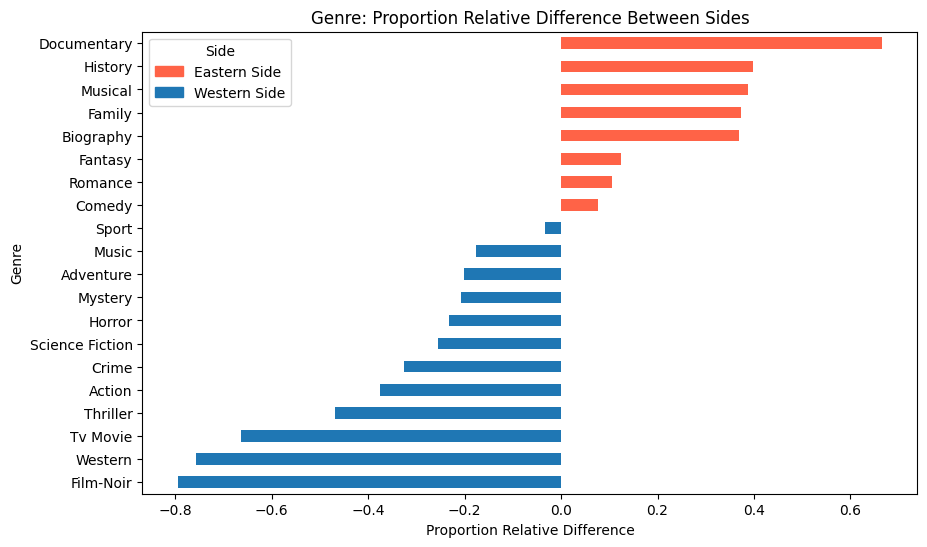

In [35]:
plot_relative_difference(genre_comparison, "Genre", abs=False, prop=True)

## Time Series


In [36]:
western_genres_yearly_counts = (
    genres_df[genres_df["cold_war_side"] == "Western"]
    .explode("genres")
    .groupby("release_date")["genres"]
    .value_counts()
).reset_index()
eastern_genres_yearly_counts = (
    genres_df[genres_df["cold_war_side"] == "Eastern"]
    .explode("genres")
    .groupby("release_date")["genres"]
    .value_counts()
).reset_index()

eastern_genres_yearly_counts = eastern_genres_yearly_counts[
    eastern_genres_yearly_counts["genres"].isin(common_genres)
]
western_genres_yearly_counts = western_genres_yearly_counts[
    western_genres_yearly_counts["genres"].isin(common_genres)
]

In [50]:
bins = [1945, 1953, 1962, 1974, 1984, 1995]
labels = [
    "Blocs Establishment",
    "Major tensions and crises",
    "Détente",
    "Second Cold War",
    "End of the Cold War",
]

# bins = list(range(1945, 1996, 5))
# labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]

genres_df["period"] = pd.cut(genres_df["release_date"], bins, labels=labels, right=True)

period_counts = (
    genres_df.explode("genres")
    .groupby(["period", "cold_war_side"], observed=False)["genres"]
    .value_counts()
    .reset_index()
)
period_counts = period_counts[period_counts["genres"].isin(common_genres)]

In [52]:
# Create Plotly figure function
def plot_genre_over_periods(
    side_genre_counts,
    genre,
    bins=[1945, 1953, 1962, 1974, 1984, 1995],
    labels=[
        "Blocs Establishment",
        "Major tensions and crises",
        "Détente",
        "Second Cold War",
        "End of the Cold War",
    ],
):
    df = side_genre_counts
    years = [bins[i + 1] - bins[i] for i in range(len(bins) - 1)]
    period_years = dict(zip(labels, years))

    # Divide counts by the number of years in the corresponding period
    df["years"] = df["period"].map(period_years)
    df["count"] = df["count"] / df["years"].astype(int)

    fig = px.bar(
        df[df["genres"] == genre],
        x="period",
        y="count",
        color="cold_war_side",
        title=f"Number Of {genre} Movies per Year Over Different Periods",
        labels={
            "period": "Period",
            "count": "Count",
            "genres": "Genres",
            "cold_war_side": "Side",
        },
        template="plotly_white",
        barmode="group",
        color_discrete_map={
            "Western": "#1f77b4",  # Assign "Western" to blue
            "Eastern": "#ff6347",  # Assign "Eastern" to red
        },
    )

    fig.update_layout(
        hovermode="x unified",
        title=dict(x=0.5, xanchor="center"),
    )
    return fig

In [54]:
pd.options.mode.chained_assignment = None  # default='warn

bins = [1945, 1953, 1962, 1974, 1984, 1995]
labels = [
    "Blocs Establishment",
    "Major tensions and crises",
    "Détente",
    "Second Cold War",
    "End of the Cold War",
]

interact(
    lambda genre: plot_genre_over_periods(
        period_counts[period_counts["cold_war_side"].isin(["Western", "Eastern"])],
        genre,
    ),
    genre=Dropdown(options=common_genres, value="War", description="Genre"),
)

interactive(children=(Dropdown(description='Genre', index=11, options=('Drama', 'Comedy', 'Romance', 'Action',…

<function __main__.<lambda>(genre)>

We see that war movies begin decreasing in frequency starting from the detente period 

# Theme Analysis

In [41]:
themes_df = (
    movies_df[["genres", "cold_war_side", "theme", "release_date"]]
    .explode("theme")
    .reset_index()
)
themes_df["theme"] = (
    themes_df["theme"]
    .str.title()
    .str.strip()
    .replace({"Wwii": "World War II", "World War Ii": "World War II"})
)
themes_df = themes_df[themes_df["theme"] != "None"].dropna(subset="genres")

theme_counts = themes_df["theme"].value_counts().head(20)

We can look at themes present in War Movies Specifically

In [44]:
eastern_war_themes = themes_df[
    (themes_df["cold_war_side"] == "Eastern")
    & (themes_df["genres"].apply(lambda x: "War" in x))
]
western_war_themes = themes_df[
    (themes_df["cold_war_side"] == "Western")
    & (themes_df["genres"].apply(lambda x: "War" in x))
]
western_war_themes_counts = western_war_themes["theme"].value_counts()
eastern_war_themes_counts = eastern_war_themes["theme"].value_counts()

In [45]:
# remove war from themes
western_war_themes_counts = western_war_themes_counts[
    western_war_themes_counts.index != "War"
]
eastern_war_themes_counts = eastern_war_themes_counts[
    eastern_war_themes_counts.index != "War"
]

plot_side_by_side(
    western_war_themes_counts.reset_index(),
    eastern_war_themes_counts.reset_index(),
    x_column="theme",
    y_column="count",
    title="Top 20 Themes for War Movies",
)

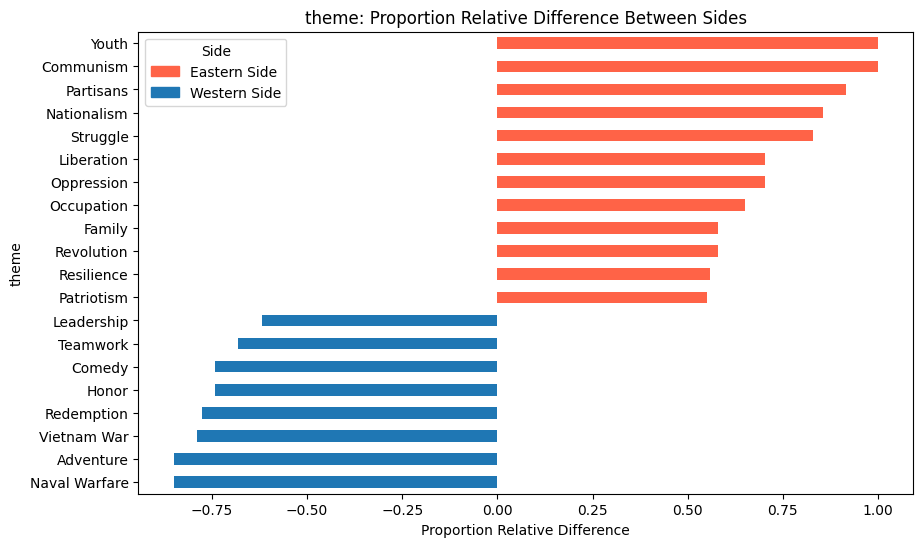

In [46]:
war_theme_comparison = create_comparison_df(
    western_war_themes_counts, eastern_war_themes_counts, 10
)

plot_relative_difference(war_theme_comparison, "theme", prop=True)

Vietnam War Movies Examples

In [47]:
movies_df.dropna(subset=["genres", "theme", "cold_war_side"])[
    (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["genres"].apply(
            lambda x: "War" in x
        )
    )
    & (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["cold_war_side"]
        == "Western"
    )
    & (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["theme"].apply(
            lambda x: "Vietnam War" in x
        )
    )
]

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
1540,Apocalypse Now,"[English, Vietnamese, French]",[United States of America],"[Drama, War, Mystery]",1979,Western,"[Benjamin L. Willard, U.S. Army Captain showin...","[Colonel Walter E. Kurtz, rogue U.S. Army offi...",[Willard representing the struggle against mad...,[Kurtz representing the dark side of human nat...,"[Psychological impact of war, morality vs. cha..."
2890,Braddock: Missing in Action III,"[English, Portuguese]",[United States of America],"[Action, War]",1988,Western,"[Colonel James Braddock, bravery, determinatio...","[General Quoc, tyranny, oppression, antagonist...","[Individualism, heroism, justice, family values]","[Oppression, totalitarianism, brutality, loss ...","[Hero's journey, redemption, Vietnam War, fami..."
3891,Cobra Mission,NaN,[Russia],"[Action, War]",1986,Western,"[Roger, James, Mark, Richard, American values,...",[None],"[Heroism, camaraderie, determination, justice,...","[Secrecy, conspiracy, oppression]","[Vietnam War, POWs, conspiracy, rescue mission..."
3989,Commander,NaN,[Russia],"[Action, War]",1988,Western,"[Commander and his band of freedom fighters, h...","[Vlasov, villainy, oppression, antagonist arch...","[Valor, bravery, individualism, anti-communism]","[Oppression, tyranny, collectivism]","[Action, war, good vs evil, heroism, Vietnam War]"
5263,Dogfight,[English],[United States of America],"[Romance, Drama, War]",1991,Western,"[Birdlace, values love, redemption, archetype ...","[Rose, values innocence, dreams, archetype of ...","[individualism, pursuit of dreams, personal gr...","[conformity, ideology, sacrifice, collectivism]","[romantic connection, Vietnam War, personal st..."
7667,Hamburger Hill,[English],[United States of America],"[Action, Drama, War, Thriller]",1987,Western,"[Sgt. Worchester, courage, camaraderie, betray...",[None],"[Courage, camaraderie, dedication to mission, ...",[None],"[Vietnam War, anti-war sentiment, military str..."
8782,In Country,[English],[Russia],"[Comedy, Romance, Drama, War]",1989,Western,"[Emmett Smith, laid-back, values family and me...",[None],"[Family, memory, resilience, healing]",[None],"[Coming-of-age, Vietnam War, loss, PTSD, famil..."
9684,Kill Zone,[English],"[Philippines, United States of America]","[Action, War, Thriller]",1993,Western,"[American colonel, individualism, hero archetype]",[None],"[Justice, fighting spirit, determination, sacr...",[None],"[War, sacrifice, individualism, Vietnam War, h..."
10260,Last Stand at Lang Mei,NaN,[Russia],"[Action, Adventure, War]",1989,Western,"[Captain Fahey, bravery, courage, hero archetype]",[None],"[American soldiers, resilience, camaraderie, p...",[None],"[War, bravery, struggle for survival, Vietnam ..."
11870,Missing in Action,"[English, Vietnamese]",[United States of America],"[Action, Thriller, Adventure, Drama, War]",1984,Western,"[Colonel James Braddock, American patriotic va...","[General Trau, authoritarianism, antagonist ar...","[Patriotism, heroism, freedom, individualism]","[Totalitarianism, oppression, militarism]","[Vietnam War, rescue mission, Cold War tensions]"


Comedy / War Movie Examples

In [48]:
movies_df.dropna(subset=["genres", "theme", "cold_war_side"])[
    (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["genres"].apply(
            lambda x: "War" in x
        )
    )
    & (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["cold_war_side"]
        == "Western"
    )
    & (
        movies_df.dropna(subset=["genres", "theme", "cold_war_side"])["theme"].apply(
            lambda x: "Comedy" in x
        )
    )
]

## first Film is British, second film is american (check on google)

,title,languages,countries,genres,release_date,cold_war_side,character_western_bloc_representation,character_eastern_bloc_representation,western_bloc_values,eastern_bloc_values,theme
5337,Don't Panic Chaps,NaN,[Russia],"[Comedy, War]",1959,Western,[ The Good Soldier],[ The Antagonist],"[Camaraderie, humor, diplomacy, peaceful coexi...","[Militarism, discipline, national pride]","[Comedy, military, peace, cultural clash ]"
12923,No Time for Sergeants,NaN,[Russia],"[Comedy, War]",1958,Western,"[Will Stockdale, values of humor, resilience, ...","[M/Sgt. King, values of mentorship and duty, a...",[None],[None],"[Comedy, military life, underdog, humor, resil..."
14430,Privates on Parade,[English],[United Kingdom],"[Comedy, Drama, War]",1983,Western,"[Major Giles Flack, Traditional British values...",[None],"[British army personnel, Comedic camaraderie, ...",[None],"[War, Comedy, Colonialism, Military entertainm..."
22666,The Wackiest Ship in the Army,[English],[United States of America],"[Comedy, Family, Drama, War]",1960,Western,"[Lieutenant Rip Crandall, determined, honorabl...",[None],"[Camaraderie, adventure, humor, teamwork]",[None],"[Comedy, military, misfits, adventure, teamwor..."
24690,"What Did You Do in the War, Daddy?","[Italian, English, German]",[United States of America],"[Comedy, War]",1966,Western,"[Lt. Christian, values friendship and camarade...","[Capitano Fausto Oppo, values tradition and co...","[American soldiers, teamwork, humor, courage, ...","[Italian officers, hospitality, the value of f...","[Comedy, war, absurdity, cultural exchange, hu..."
24807,Which Way to the Front?,[English],[United States of America],"[Comedy, War]",1970,Western,"[Brendan Byers III, rich, patriotic, resourcef...",[None],"[Patriotism, resourcefulness, individualism, H...",[None],"[Comedy, War, Heroism, patriotism, improvisation]"
